### Изучение данных
Цель данного блокнота состоит в том, чтобы в первый раз взглянуть на данные, понять их природу, сделать все необходимые проверки для обеспечения надежности в дальнейшей работе и подготовиться к feature engineering.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import tldextract

%matplotlib inline
from matplotlib import pyplot as plot

from itertools import islice
from math import isnan, exp, log
from urllib.parse import urlparse
from ipaddress import ip_address

from modules.utils import print_versions, unpickle

In [2]:
print_versions([ np, pd, matplotlib, tldextract ])

Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
 -  numpy 1.18.1
 -  pandas 1.0.0
 -  matplotlib 3.1.2
 -  tldextract 2.2.0


In [3]:
sites_dictionary = unpickle('./data/site_dic.pkl')
print('Sites dicitionary is read, type "{}", length {}'.format(type(sites_dictionary), len(sites_dictionary)))

Sites dicitionary is read, type "<class 'dict'>", length 48371


In [4]:
print(*islice(sites_dictionary.items(), 3))

('www.abmecatronique.com', 25075) ('groups.live.com', 13997) ('majeureliguefootball.wordpress.com', 42436)


In [5]:
sessions = pd.read_csv('./data/train_sessions.csv')
print('Sessions data is read')
print(sessions.info())

Sessions data is read
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non

In [6]:
sessions.head(2)

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0


In [7]:
sessions.tail(2)

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
253559,253560,812,2013-12-19 15:20:22,676.0,2013-12-19 15:20:22,814.0,2013-12-19 15:20:22,22.0,2013-12-19 15:20:22,39.0,...,2013-12-19 15:20:23,814.0,2013-12-19 15:20:23,570.0,2013-12-19 15:20:23,22.0,2013-12-19 15:20:24,570.0,2013-12-19 15:20:24,0
253560,253561,34942,2014-04-25 09:56:52,1429.0,2014-04-25 09:56:53,34942.0,2014-04-25 09:56:53,29.0,2014-04-25 09:56:54,30.0,...,2014-04-25 09:56:54,5779.0,2014-04-25 09:56:54,30.0,2014-04-25 09:56:55,35.0,2014-04-25 09:56:55,33.0,2014-04-25 09:56:55,0


In [8]:
print(sessions['target'].value_counts())

0    251264
1      2297
Name: target, dtype: int64


__Классы несбалансированы, возможно придется применять under/over-sampling или балансирующие метрики, для корректного поиска оптимального классификатора__

__Фикс данных и проверка целостности:__

In [9]:
assert len({ *sites_dictionary.values() }) == len(sites_dictionary)
print('Sites dictionary is valid and can be inverted')

Sites dictionary is valid and can be inverted


In [10]:
sites_dictionary = { key: value for (value, key) in sites_dictionary.items() }

In [11]:
print(*islice(sites_dictionary.items(), 3))
print('... {} total'.format(len(sites_dictionary)))

(25075, 'www.abmecatronique.com') (13997, 'groups.live.com') (42436, 'majeureliguefootball.wordpress.com')
... 48371 total


In [12]:
features_range = range(1, 11)
site_features_names = [ 'site{}'.format(i) for i in features_range ]
time_features_names = [ 'time{}'.format(i) for i in features_range ]

In [13]:
sessions.set_index('session_id', inplace=True, verify_integrity=True)

In [14]:
def is_any_type_of_integer(value):    
    if value == np.nan or isnan(value):
        return True
    
    if (type(value) is int) or np.issubdtype(type(value), np.integer):
        return True
    
    if (type(value) is float):
        return value.is_integer()
    
    if np.issubdtype(type(value), np.floating):
        return value.astype(float).is_integer()
    
    return False

for column in (sessions.loc[:, site_features_names]):
    for (index, scalar) in enumerate(sessions[column]):
        assert is_any_type_of_integer(scalar), '({}, {}) {} is nor integer, neither nan'.format(index, column, scalar)
        assert (scalar == np.nan) or isnan(scalar) or (np.int(scalar) in sites_dictionary), '({}, {}) {} is not valid index for sites'.format(index, column, scalar)
        
print('Sessions and sites dictionary referential integrity is checked, site indexes are either ints or nans')

Sessions and sites dictionary referential integrity is checked, site indexes are either ints or nans


In [15]:
sessions.loc[:, time_features_names] = sessions.astype(dtype={ column: 'datetime64[ns]' for column in time_features_names })
sessions.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0


In [16]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  date

__Нарушений целостности, неправильного форматирования или каких-либо других ошибок не обнаружено, теперь можно изучать сами данные__

In [17]:
year_bins = dict()
month_bins = dict()
weekday_bins = dict()
hour_bins = dict()

seconds_delta_per_site = []

no_scalar_after_nat = True
not_dense_than_seconds = True

def add_to_bin(bins, value):
    if value in bins:
        bins[value] = bins[value] + 1
    else:
        bins[value] = 0

for (index, row) in sessions[time_features_names].iterrows():
    has_nulls = False
    start_timestamp = None
    
    for timestamp in row:
        if pd.isnull(timestamp):
            has_nulls = True
            continue
        
        assert type(timestamp) is pd.Timestamp, (index, timestamp, type(timestamp))
        
        if has_nulls:
            no_scalar_after_nat = False
            
        if timestamp.microsecond != 0:
            not_dense_than_seconds = False
        
        add_to_bin(year_bins, timestamp.year)
        add_to_bin(month_bins, timestamp.month)
        add_to_bin(weekday_bins, timestamp.isoweekday())
        add_to_bin(hour_bins, timestamp.hour)
        
        if start_timestamp == None:
            start_timestamp = timestamp
        else:
            seconds_delta_per_site.append((timestamp - start_timestamp).total_seconds())
            start_timestamp = timestamp

In [18]:
print('In sessions time data there is no normal data after null:', no_scalar_after_nat)
print('In sessions time data lowest resolution is seconds:', not_dense_than_seconds)

In sessions time data there is no normal data after null: True
In sessions time data lowest resolution is seconds: True


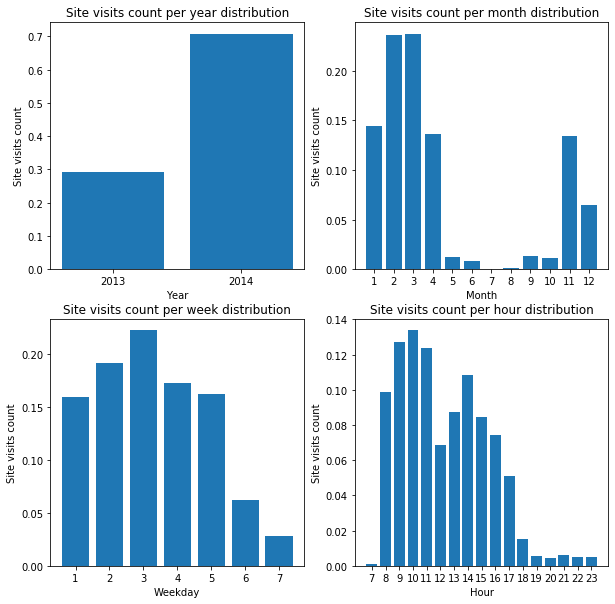

In [19]:
figure, axes = plot.subplots(2, 2, figsize=(10, 10), clear=True)
figure.suptitle('')

year_bins_total = sum(year_bins.values())
                      
axes[0, 0].bar([ str(y) for y in sorted(year_bins) ], [ (year_bins[y] / year_bins_total) for y in sorted(year_bins) ])
axes[0, 0].set(title='Site visits count per year distribution', ylabel='Site visits count', xlabel='Year')

month_bins_total = sum(month_bins.values())

axes[0, 1].bar([ str(m) for m in sorted(month_bins) ], [ (month_bins[m] / month_bins_total) for m in sorted(month_bins) ])
axes[0, 1].set(title='Site visits count per month distribution', ylabel='Site visits count', xlabel='Month')

weekday_bins_total = sum(weekday_bins.values())

axes[1, 0].bar([ str(w) for w in sorted(weekday_bins) ], [ (weekday_bins[w] / weekday_bins_total) for w in sorted(weekday_bins) ])
axes[1, 0].set(title='Site visits count per week distribution', ylabel='Site visits count', xlabel='Weekday')

hour_bins_total = sum(hour_bins.values())

axes[1, 1].bar([ str(h) for h in sorted(hour_bins) ], [ (hour_bins[h] / hour_bins_total) for h in sorted(hour_bins) ])
axes[1, 1].set(title='Site visits count per hour distribution', ylabel='Site visits count', xlabel='Hour')

plot.show()

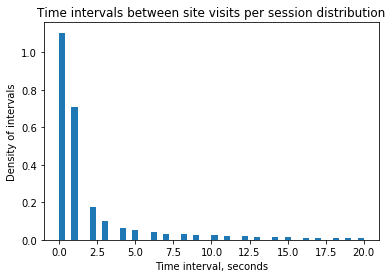

In [20]:
plot.hist(seconds_delta_per_site, bins=50, range=(0, 20), density=True)
plot.title('Time intervals between site visits per session distribution')
plot.xlabel('Time interval, seconds')
plot.ylabel('Density of intervals')
plot.show()

In [21]:
upper_count = len([ s for s in seconds_delta_per_site if s > 20 ])
lower_count = len([ s for s in seconds_delta_per_site if s <= 20 ])
print('Sites visits seconds delta > 20 to <= 20 ratio:', round(upper_count / lower_count, 3))

Sites visits seconds delta > 20 to <= 20 ratio: 0.126


In [22]:
print('Sites visits seconds delta 95 percentile is', np.quantile(seconds_delta_per_site, .95))

Sites visits seconds delta 95 percentile is 60.0


In [23]:
print('Sites visits seconds delta logarithmic 95 percentile is', np.quantile([ log(1+s) for s in seconds_delta_per_site ], .95))

Sites visits seconds delta logarithmic 95 percentile is 4.110873864173311


In [24]:
rare_values = sum([ month_bins[i] for i in range(5, 11) ])
total_values = sum(month_bins.values())
print('Site visit month from 5 to 10 per total ratio:', round(rare_values / total_values, 3))

Site visit month from 5 to 10 per total ratio: 0.047


In [25]:
rare_values = sum([ hour_bins[i] for i in [ 7, *range(19, 24) ] ])
total_values = sum(hour_bins.values())
print('Site visit hours from 1 to 8 and from 19 to 24 per total ratio:', round(rare_values / total_values, 3))

Site visit hours from 1 to 8 and from 19 to 24 per total ratio: 0.027


In [26]:
rare_values = sum([ weekday_bins[i] for i in [ 6, 7 ] ])
total_values = sum(weekday_bins.values())
print('Site visit weekday from 6 to 7 per total ratio:', round(rare_values / total_values, 3))

Site visit weekday from 6 to 7 per total ratio: 0.09


In [27]:
non_suffixed_domains = set()

for url_raw in sites_dictionary.values():
    url = urlparse(url_raw)
    
    conditions = [
        url.path != '',
        
        url.scheme == '',
        url.netloc == '',
        url.query == '',
        url.fragment == '',
        
        url.username == None,
        url.password == None,
        url.hostname == None,
        url.port == None
    ]
    
    assert all(conditions), url
        
    url = urlparse('//' + url_raw, scheme='http')
    
    conditions = [
        url.netloc != '',
        url.path == ''
    ]
    
    assert all(conditions), url
        
    url_domains = tldextract.extract(url.netloc)
    
    conditions = [
        url_domains.domain != ''
    ]
    
    assert all(conditions), (url, url_domains)
    
    if url_domains.suffix == '':
        non_suffixed_domains.add(url_domains.domain)
    
print('Confirmed assumed simple implicit url format consisting of only dot separated domain names')

Confirmed assumed simple implicit url format consisting of only dot separated domain names


In [28]:
print(*islice(non_suffixed_domains, 5))

94.23.236.222 202.183.54.12 178.79.162.68 115.30.191.21 208.74.204.114


In [29]:
for domain in non_suffixed_domains:
    ip = ip_address(domain)
    
    assert ip.version == 4, domain
    
print('Confirmed assumed IPv4 non suffixed domains')

Confirmed assumed IPv4 non suffixed domains


In [30]:
print('IPv4 vs all url ratio:', round(len(non_suffixed_domains) / len(sites_dictionary), 3))

IPv4 vs all url ratio: 0.002


## Выводы
* Классы очень сильно несбалансированы, необходимо это учесть в метриках
* Данные проверены и готовы к извлечению признаков, требуется только предобработка null'ов
* Во временных данных заметна некая "сезонность":
  * Так сессии в месяцы с 5 по 10 включительно составляют меньше 5 процентов от всех сессий
  * Сессии до 8 утра и после 7 вечера составляют долю меньше 3 процентов от всех сессий
  * 95 процентов временых интервалов между посещениями сайтов в рамках одной сесии помещяются в одну минуту
  * К этим данным нужно присмотреться более подробно и выкинуть соответствующие значения, если они окажутся шумом
* Информация о посещенных сайтах хранится в виде доменных имен или ip адресов, последних очень мало и вряд ли они содержат какую-либо полезную информацию